# Import Library

In [1]:
pip install yfinance


In [1]:
# Load data
import yfinance as yf
import pandas as pd
import numpy as np
import os
from datetime import datetime
import time

#EDA
from statsmodels.tsa.seasonal import seasonal_decompose

# Data preparation
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

# Modelling
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Inference & save model
import json
from datetime import datetime
import tensorflow as tf
import joblib


# Load data

In [2]:
def get_audusd_data(start_date='2015-01-01', end_date=None, csv_path='audusd_data.csv', force_download=False, delay=5):
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')

    if not force_download and os.path.exists(csv_path):
        print(f"Membaca data dari cache: {csv_path}")
        data = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    else:
        print(f"Mengunduh data AUD/USD dari Yahoo Finance: {start_date} sampai {end_date}")
        time.sleep(delay)
        data = yf.download('AUDUSD=X', start=start_date, end=end_date)

        # Ambil hanya 5 kolom yang diinginkan
        columns_to_keep = ['Close', 'High', 'Low', 'Open', 'Volume']
        data = data[columns_to_keep]

        # Ganti nama kolom sesuai urutan (agar mudah pada data preparation)
        data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

        data.to_csv(csv_path)
        print(f"Data disimpan ke {csv_path}")

    return data

data = get_audusd_data(end_date=None)  # end_date=None untuk hari ini


Mengunduh data AUD/USD dari Yahoo Finance: 2015-01-01 sampai 2025-06-09
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data disimpan ke audusd_data.csv


# EDA

## Cek missing value & duplikat

In [3]:
data.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [4]:
data.duplicated().sum()

np.int64(0)

## Meneliti 5 data terakhir

In [5]:
data.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2025-06-02,0.644322,0.650030,0.644322,0.644322,0
2025-06-03,0.649840,0.649929,0.644930,0.649899,0
2025-06-04,0.646609,0.650406,0.645170,0.646509,0
2025-06-05,0.649068,0.653900,0.648650,0.649001,0
2025-06-06,0.651050,0.651806,0.648020,0.651131,0


## Meneliti dimensi dataset

In [6]:
print("Dimensi dataset:", data.shape)

Dimensi dataset: (2716, 5)


## Meneliti nilai

In [7]:
data.describe()

,Close,High,Low,Open,Volume
count,2716.000000,2716.000000,2716.000000,2716.000000,2716.0
mean,0.713360,0.716527,0.710272,0.713389,0.0
std,0.047786,0.047781,0.047771,0.047762,0.0
min,0.574290,0.584020,0.552000,0.574640,0.0
25%,0.674033,0.676778,0.671265,0.674087,0.0
50%,0.716271,0.719011,0.713061,0.716307,0.0
75%,0.754379,0.757146,0.751103,0.754294,0.0
max,0.822707,0.829394,0.819739,0.822707,0.0


### Insight :    
- Nilai volume 0, karena pasangan USD sering tidak ditampilkan data nya oleh beberapa pihak, salah satunya platform sumber kami yaitu Yahoo Finance
- Volume akan dihapus karena tidak memiliki pengaruh pada time series, karena tidak ada datanya.

## Visualisasi Tren Harga

<Axes: title={'center': 'AUD/USD Closing Price'}, xlabel='Date'>

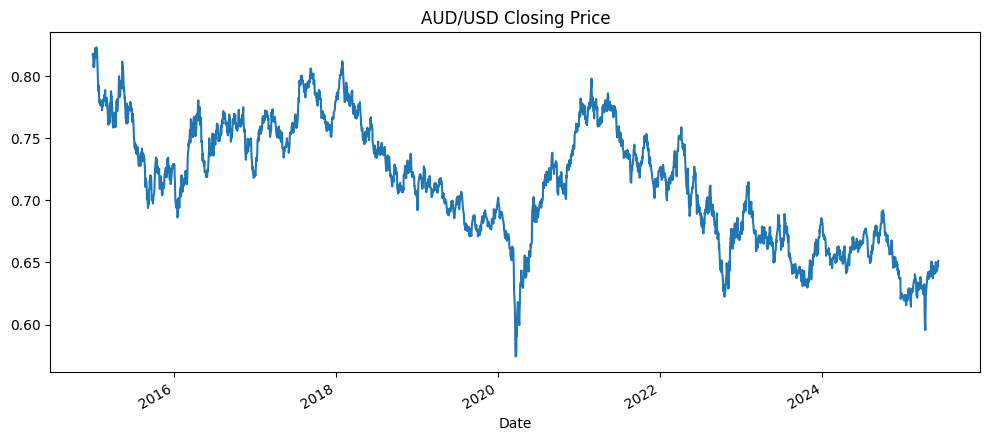

In [8]:
data['Close'].plot(figsize=(12, 5), title='AUD/USD Closing Price')

## Seasonality & Trend

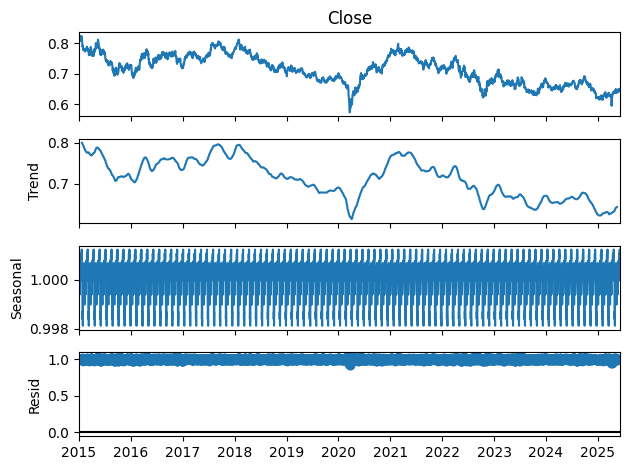

In [9]:
result = seasonal_decompose(data['Close'], model='multiplicative', period=30)
result.plot();

### Insight :     
- AUD/USD memiliki fluktuasi tren jangka panjang
- Ada kenaikan signifikan antara 2020–2021.
- Fluktuasi seasonal cukup kecil dalam skala.
- 2018-2021, terjadi penurunan tren yang cukup lama yang disebabkan oleh kombinasi faktor ekonomi global, domestik Australia, dan sentimen pasar terhadap risiko
- Setelah 2021, terjadi penurunan tren yang cukup lama hingga 2024. Kemungkinan besar karena efek pandemi corona.
- Terdapat fase tren naik dan turun yang panjang, cocok untuk digunakan dalam strategi long-term trading atau hedging.

## Boxplot

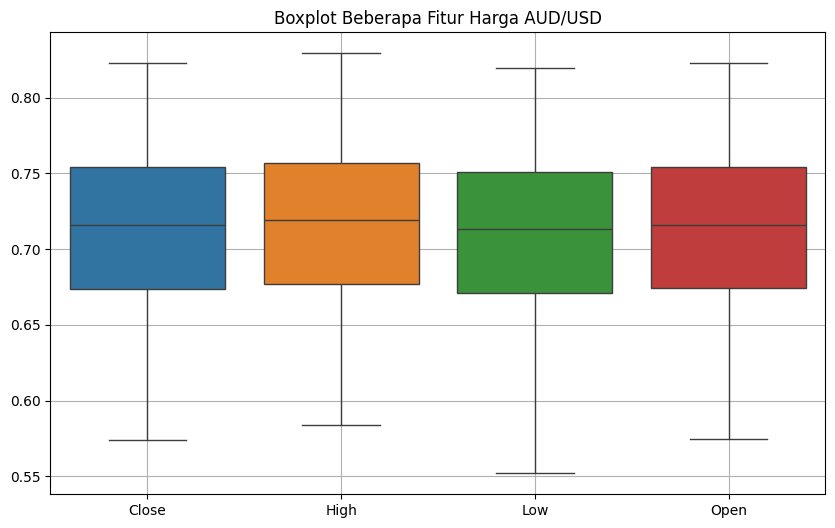

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['Close', 'High', 'Low', 'Open']])
plt.title("Boxplot Beberapa Fitur Harga AUD/USD")
plt.grid(True)
plt.show()

### Insight :
- Distribusi merata dan bersih

# Data Preprocessing

In [11]:
# 1. Memastikan index dataframe adalah date
print(data.index)

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-12',
               '2015-01-13', '2015-01-14',
               ...
               '2025-05-26', '2025-05-27', '2025-05-28', '2025-05-29',
               '2025-05-30', '2025-06-02', '2025-06-03', '2025-06-04',
               '2025-06-05', '2025-06-06'],
              dtype='datetime64[ns]', name='Date', length=2716, freq=None)


In [12]:
# 2. Menghapus kolom volume
data.drop(columns=['Volume'], inplace=True)

# 3. Hitung perubahan harga harian (Price Change)
data['Price_Change'] = data['Close'].diff().fillna(0)

# 4. Klasifikasi perubahan harga (Price Range Class)
def classify_price_range(change):
    if change <= -0.01:
        return 'turunjauh'
    elif change <= -0.001:
        return 'turundekat'
    elif change > 0.01:
        return 'naikjauh'
    elif change > 0.001:
        return 'naikdekat'
    else:
        return 'stabil'

# 5. Klasifikasi range high-low harian (Volatilitas)
def classify_high_low_range(row):
    hl_range = row['High'] - row['Low']
    if hl_range > 0.01:
        return 'rangebesar'
    elif hl_range > 0.001:
        return 'rangesedang'
    elif hl_range > 0.0001:
        return 'rangekecil'
    else:
        return 'rangetipis'

data['Price_Range_Class'] = data['Price_Change'].apply(classify_price_range)
data['High_Low_Range_Class'] = data.apply(classify_high_low_range, axis=1)

# 6. Hitung RSI
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])

# 7. Moving Averages
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()

# 8. Hitung MACD
def compute_macd(series, fast_period=12, slow_period=26, signal_period=9):
    exp1 = series.ewm(span=fast_period, adjust=False).mean()
    exp2 = series.ewm(span=slow_period, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal_line

data['MACD'], data['MACD_Signal'] = compute_macd(data['Close'])

# 8. Drop NA rows (karena MA dan RSI awal akan kosong)
data.dropna(inplace=True)

In [13]:
# Meneliti 5 data terakhir setelah menambahkan fitur baru
print("Data dengan fitur baru:")
data.tail()

Data dengan fitur baru:


,Close,High,Low,Open,Price_Change,Price_Range_Class,High_Low_Range_Class,RSI,MA_5,MA_10,MACD,MACD_Signal
Date,,,,,,,,,,,,
2025-06-02,0.644322,0.650030,0.644322,0.644322,-0.000278,stabil,rangesedang,57.617807,0.644851,0.644685,0.002296,0.002770
2025-06-03,0.649840,0.649929,0.644930,0.649899,0.005518,naikdekat,rangesedang,53.046139,0.645199,0.645110,0.002585,0.002733
2025-06-04,0.646609,0.650406,0.645170,0.646509,-0.003231,turundekat,rangesedang,54.528291,0.645578,0.645511,0.002524,0.002691
2025-06-05,0.649068,0.653900,0.648650,0.649001,0.002459,naikdekat,rangesedang,60.271477,0.646888,0.646087,0.002644,0.002682
2025-06-06,0.651050,0.651806,0.648020,0.651131,0.001982,naikdekat,rangesedang,61.716337,0.648178,0.647094,0.002866,0.002719


# Data Preparation

In [14]:
# 1. Membuat target NAIK/TURUN t+1 s.d. t+5 (senin-jum'at)
for offset in range(1, 6):
    data[f'Close_t+{offset}'] = data['Close'].shift(-offset)
    data[f'Target_t+{offset}'] = (data[f'Close_t+{offset}'] > data['Close']).astype(int)

data.dropna(inplace=True)

In [15]:
# 2. Normalisasi numerik
scaler = MinMaxScaler()
data[['Close', 'RSI', 'MA_5', 'MA_10', 'MACD']] = scaler.fit_transform(data[['Close', 'RSI', 'MA_5', 'MA_10', 'MACD']])

# 3. One-hot encoding
data = pd.get_dummies(data, columns=['Price_Range_Class', 'High_Low_Range_Class'])

# 4. Sequence LSTM
window_size = 90  # Bisa dioptimalkan nanti
features = data.drop(columns=[f'Close_t+{i}' for i in range(1, 6)] + [f'Target_t+{i}' for i in range(1, 6)]).values
targets = data[[f'Target_t+{i}' for i in range(1, 6)]].values

X, y = [], []
for i in range(len(features) - window_size):
    X.append(features[i:i+window_size])
    y.append(targets[i+window_size])

X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.int32)

In [16]:
# Meneliti 5 data terakhir setelah normalisasi
print("Data dengan fitur baru:")
data.tail()

Data dengan fitur baru:


,Close,High,Low,Open,Price_Change,RSI,MA_5,MA_10,MACD,MACD_Signal,...,Target_t+5,Price_Range_Class_naikdekat,Price_Range_Class_naikjauh,Price_Range_Class_stabil,Price_Range_Class_turundekat,Price_Range_Class_turunjauh,High_Low_Range_Class_rangebesar,High_Low_Range_Class_rangekecil,High_Low_Range_Class_rangesedang,High_Low_Range_Class_rangetipis
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-26,0.309193,0.653761,0.649452,0.650250,0.009138,0.576372,0.259838,0.219707,0.689697,0.003136,...,0,True,False,False,False,False,False,False,True,False
2025-05-27,0.300964,0.649700,0.643520,0.648059,-0.002018,0.516971,0.261971,0.224605,0.693898,0.003134,...,1,False,False,False,True,False,False,False,True,False
2025-05-28,0.287146,0.645600,0.641079,0.644820,-0.003389,0.553148,0.263760,0.223461,0.688992,0.003097,...,1,False,False,False,True,False,False,False,True,False
2025-05-29,0.278211,0.646100,0.640930,0.642178,-0.002191,0.574618,0.263091,0.223300,0.679567,0.002996,...,1,False,False,False,True,False,False,False,True,False
2025-05-30,0.286688,0.645249,0.640810,0.644479,0.002079,0.567206,0.266157,0.225104,0.675833,0.002888,...,1,True,False,False,False,False,False,False,True,False


In [17]:
# 5. Menyiapkan data untuk model klasifikasi dan regresi
data_cls = data.copy()
data_reg = data.copy()

In [18]:
# 6. Target regresi (harga penutupan)
regression_targets = data_reg[[f'Close_t+{i}' for i in range(1, 6)]].values

# Menggunakan fitur yang sama
X_reg = []
y_reg = []
for i in range(len(features) - window_size):
    X_reg.append(features[i:i+window_size])
    y_reg.append(regression_targets[i+window_size])

X_reg = np.array(X_reg).astype(np.float32)
y_reg = np.array(y_reg).astype(np.float32)

# Modelling

## Klasifikasi (Naik/Turun)

### Split Data

In [19]:
# Split Data
X_cls = np.array(X).astype(np.float32)
y_cls = np.array(y).astype(np.int32)

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
    )

### Build Model

In [20]:
# Build Model
model_cls = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(5, activation='sigmoid')  # output 5 hari
])

model_cls.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cls.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 64)         │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,085 (133.14 KB)

 Trainable params: 34,085 (133.14 KB)

 Non-trainable params: 0 (0.00 B)

### Train

In [21]:
# Checkpoint untuk menyimpan model terbaik
checkpoint_cls = ModelCheckpoint('best_model_cls.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train model
history = model_cls.fit(
    X_train_cls, y_train_cls,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint_cls],
    verbose=1
)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3147 - loss: 0.6965
Epoch 1: val_loss improved from inf to 0.69659, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.3146 - loss: 0.6965 - val_accuracy: 0.6914 - val_loss: 0.6966
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.2410 - loss: 0.6949 
Epoch 2: val_loss improved from 0.69659 to 0.69386, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.2406 - loss: 0.6948 - val_accuracy: 0.5622 - val_loss: 0.6939
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.4521 - loss: 0.6926
Epoch 3: val_loss improved from 0.69386 to 0.69197, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.4514 - loss: 0.6926 - val_accuracy: 0.0598 - val_loss: 0.6920
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2709 - loss: 0.6934
Epoch 4: val_loss did not improve from 0.69197
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.2726 - loss: 0.6934 - val_accuracy: 0.4498 - val_loss: 0.6926
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3413 - loss: 0.6916
Epoch 5: val_loss improved from 0.69197 to 0.69160, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.3405 - loss: 0.6916 - val_accuracy: 0.2656 - val_loss: 0.6916
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2859 - loss: 0.6906
Epoch 6: val_loss did not improve from 0.69160
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.2868 - loss: 0.6906 - val_accuracy: 0.5670 - val_loss: 0.6957
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4088 - loss: 0.6917
Epoch 7: val_loss improved from 0.69160 to 0.69050, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.4073 - loss: 0.6917 - val_accuracy: 0.3493 - val_loss: 0.6905
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3949 - loss: 0.6874
Epoch 8: val_loss did not improve from 0.69050
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.3949 - loss: 0.6874 - val_accuracy: 0.2895 - val_loss: 0.6905
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4062 - loss: 0.6904
Epoch 9: val_loss improved from 0.69050 to 0.68903, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.4056 - loss: 0.6904 - val_accuracy: 0.1699 - val_loss: 0.6890
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4099 - loss: 0.6874
Epoch 10: val_loss improved from 0.68903 to 0.68786, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.4101 - loss: 0.6875 - val_accuracy: 0.0718 - val_loss: 0.6879
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1536 - loss: 0.6910
Epoch 11: val_loss did not improve from 0.68786
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.1549 - loss: 0.6910 - val_accuracy: 0.2512 - val_loss: 0.6885
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.1930 - loss: 0.6900
Epoch 12: val_loss did not improve from 0.68786
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.1938 - loss: 0.6899 - val_accuracy: 0.5718 - val_loss: 0.6925
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4716 - loss: 0.6870
Epoch 13: val_loss improved from 0.68786 to 0.68710, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.4704 - loss: 0.6871 - val_accuracy: 0.4593 - val_loss: 0.6871
Epoch 14/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3716 - loss: 0.6894
Epoch 14: val_loss did not improve from 0.68710
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.3732 - loss: 0.6894 - val_accuracy: 0.4641 - val_loss: 0.6908
Epoch 15/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2462 - loss: 0.6886
Epoch 15: val_loss did not improve from 0.68710
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.2461 - loss: 0.6886 - val_accuracy: 0.5167 - val_loss: 0.6909
Epoch 16/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4323 - loss: 0.6898
Epoch 16: val_loss improved from 0.68710 to 0.68477, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.4314 - loss: 0.6897 - val_accuracy: 0.4689 - val_loss: 0.6848
Epoch 17/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4506 - loss: 0.6838
Epoch 17: val_loss improved from 0.68477 to 0.68395, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.4508 - loss: 0.6838 - val_accuracy: 0.5144 - val_loss: 0.6840
Epoch 18/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3723 - loss: 0.6849
Epoch 18: val_loss did not improve from 0.68395
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.3722 - loss: 0.6849 - val_accuracy: 0.4115 - val_loss: 0.6911
Epoch 19/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3554 - loss: 0.6893
Epoch 19: val_loss did not improve from 0.68395
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.3558 - loss: 0.6893 - val_accuracy: 0.3014 - val_loss: 0.6939
Epoch 20/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2951 - loss: 0.6895
Epoch 20: val_loss did not improve from 0.68395
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.2959 - loss: 0.6894 - val_accuracy: 0.2368 - val_loss: 0.6967
Epoch 21/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3371 - loss: 0.6908
Epoch 21: val_loss did not improve from 0.6

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.4463 - loss: 0.6872 - val_accuracy: 0.4498 - val_loss: 0.6833
Epoch 31/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4316 - loss: 0.6825
Epoch 31: val_loss did not improve from 0.68333
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.4306 - loss: 0.6825 - val_accuracy: 0.4665 - val_loss: 0.6866
Epoch 32/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5218 - loss: 0.6842
Epoch 32: val_loss improved from 0.68333 to 0.68222, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.5217 - loss: 0.6842 - val_accuracy: 0.4354 - val_loss: 0.6822
Epoch 33/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3863 - loss: 0.6793
Epoch 33: val_loss did not improve from 0.68222
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.3864 - loss: 0.6793 - val_accuracy: 0.4330 - val_loss: 0.6824
Epoch 34/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4352 - loss: 0.6836
Epoch 34: val_loss improved from 0.68222 to 0.68188, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.4352 - loss: 0.6836 - val_accuracy: 0.4856 - val_loss: 0.6819
Epoch 35/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4363 - loss: 0.6797
Epoch 35: val_loss improved from 0.68188 to 0.68075, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.4360 - loss: 0.6797 - val_accuracy: 0.4450 - val_loss: 0.6807
Epoch 36/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4016 - loss: 0.6795
Epoch 36: val_loss did not improve from 0.68075
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.4017 - loss: 0.6795 - val_accuracy: 0.4904 - val_loss: 0.6866
Epoch 37/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3675 - loss: 0.6760
Epoch 37: val_loss did not improve from 0.68075
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.3670 - loss: 0.6761 - val_accuracy: 0.2584 - val_loss: 0.6819
Epoch 38/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3000 - loss: 0.6780
Epoch 38: val_loss improved from 0.68075 to 0.68054, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.3010 - loss: 0.6780 - val_accuracy: 0.4474 - val_loss: 0.6805
Epoch 39/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3985 - loss: 0.6768
Epoch 39: val_loss improved from 0.68054 to 0.67864, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.3985 - loss: 0.6768 - val_accuracy: 0.3852 - val_loss: 0.6786
Epoch 40/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4504 - loss: 0.6706
Epoch 40: val_loss did not improve from 0.67864
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.4499 - loss: 0.6707 - val_accuracy: 0.2344 - val_loss: 0.6813
Epoch 41/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3137 - loss: 0.6688
Epoch 41: val_loss did not improve from 0.67864
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.3140 - loss: 0.6689 - val_accuracy: 0.4474 - val_loss: 0.6820
Epoch 42/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3664 - loss: 0.6702
Epoch 42: val_loss did not improve from 0.67864
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.3657 - loss: 0.6704 - val_accuracy: 0.3278 - val_loss: 0.6844
Epoch 43/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3330 - loss: 0.6725
Epoch 43: val_loss improved from 0.67864 t

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.3335 - loss: 0.6725 - val_accuracy: 0.2847 - val_loss: 0.6757
Epoch 44/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3513 - loss: 0.6655
Epoch 44: val_loss did not improve from 0.67573
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.3513 - loss: 0.6656 - val_accuracy: 0.2057 - val_loss: 0.6791
Epoch 45/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3031 - loss: 0.6766
Epoch 45: val_loss did not improve from 0.67573
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.3036 - loss: 0.6765 - val_accuracy: 0.4115 - val_loss: 0.6785
Epoch 46/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3801 - loss: 0.6550
Epoch 46: val_loss improved from 0.67573 to 0.67418, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.3799 - loss: 0.6550 - val_accuracy: 0.3589 - val_loss: 0.6742
Epoch 47/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3305 - loss: 0.6607
Epoch 47: val_loss improved from 0.67418 to 0.66351, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.3308 - loss: 0.6607 - val_accuracy: 0.3278 - val_loss: 0.6635
Epoch 48/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3582 - loss: 0.6516
Epoch 48: val_loss did not improve from 0.66351
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.3567 - loss: 0.6519 - val_accuracy: 0.3517 - val_loss: 0.6688
Epoch 49/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2904 - loss: 0.6530
Epoch 49: val_loss did not improve from 0.66351
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.2911 - loss: 0.6531 - val_accuracy: 0.4234 - val_loss: 0.6680
Epoch 50/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3529 - loss: 0.6524
Epoch 50: val_loss did not improve from 0.66351
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.3528 - loss: 0.6525 - val_accuracy: 0.3780 - val_loss: 0.6815
Epoch 51/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3552 - loss: 0.6530
Epoch 51: val_loss did not improve from 0.66

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.3138 - loss: 0.6455 - val_accuracy: 0.3517 - val_loss: 0.6621
Epoch 53/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3355 - loss: 0.6382
Epoch 53: val_loss improved from 0.66214 to 0.65896, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.3355 - loss: 0.6381 - val_accuracy: 0.2919 - val_loss: 0.6590
Epoch 54/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3108 - loss: 0.6403
Epoch 54: val_loss did not improve from 0.65896
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.3113 - loss: 0.6403 - val_accuracy: 0.3923 - val_loss: 0.6612
Epoch 55/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3773 - loss: 0.6320
Epoch 55: val_loss did not improve from 0.65896
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.3773 - loss: 0.6320 - val_accuracy: 0.3134 - val_loss: 0.6627
Epoch 56/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3352 - loss: 0.6310
Epoch 56: val_loss improved from 0.65896 to 0.65748, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.3350 - loss: 0.6310 - val_accuracy: 0.3684 - val_loss: 0.6575
Epoch 57/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3810 - loss: 0.6225
Epoch 57: val_loss improved from 0.65748 to 0.65072, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.3809 - loss: 0.6225 - val_accuracy: 0.3373 - val_loss: 0.6507
Epoch 58/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3802 - loss: 0.6227
Epoch 58: val_loss did not improve from 0.65072
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.3804 - loss: 0.6228 - val_accuracy: 0.3397 - val_loss: 0.6554
Epoch 59/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3014 - loss: 0.6426
Epoch 59: val_loss improved from 0.65072 to 0.64360, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.3019 - loss: 0.6424 - val_accuracy: 0.3254 - val_loss: 0.6436
Epoch 60/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3522 - loss: 0.6186
Epoch 60: val_loss did not improve from 0.64360
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.3522 - loss: 0.6186 - val_accuracy: 0.3014 - val_loss: 0.6641
Epoch 61/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3201 - loss: 0.6142
Epoch 61: val_loss improved from 0.64360 to 0.63664, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.3203 - loss: 0.6143 - val_accuracy: 0.3182 - val_loss: 0.6366
Epoch 62/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3203 - loss: 0.6303
Epoch 62: val_loss improved from 0.63664 to 0.63240, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.3204 - loss: 0.6301 - val_accuracy: 0.3565 - val_loss: 0.6324
Epoch 63/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.3809 - loss: 0.6100
Epoch 63: val_loss did not improve from 0.63240
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.3809 - loss: 0.6100 - val_accuracy: 0.3612 - val_loss: 0.6500
Epoch 64/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3628 - loss: 0.6011
Epoch 64: val_loss did not improve from 0.63240
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.3629 - loss: 0.6011 - val_accuracy: 0.3421 - val_loss: 0.6449
Epoch 65/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3682 - loss: 0.5874
Epoch 65: val_loss did not improve from 0.63240
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.3680 - loss: 0.5875 - val_accuracy: 0.3158 - val_loss: 0.6410
Epoch 66/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3464 - loss: 0.5947
Epoch 66: val_loss did not improve from 0

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.3809 - loss: 0.5691 - val_accuracy: 0.3397 - val_loss: 0.6248
Epoch 74/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3533 - loss: 0.5628
Epoch 74: val_loss did not improve from 0.62484
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.3534 - loss: 0.5629 - val_accuracy: 0.3206 - val_loss: 0.6256
Epoch 75/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3485 - loss: 0.5581
Epoch 75: val_loss improved from 0.62484 to 0.62336, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.3488 - loss: 0.5581 - val_accuracy: 0.3541 - val_loss: 0.6234
Epoch 76/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3572 - loss: 0.5533
Epoch 76: val_loss improved from 0.62336 to 0.61505, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.3574 - loss: 0.5533 - val_accuracy: 0.3493 - val_loss: 0.6150
Epoch 77/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3736 - loss: 0.5746
Epoch 77: val_loss did not improve from 0.61505
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.3737 - loss: 0.5745 - val_accuracy: 0.3397 - val_loss: 0.6187
Epoch 78/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3785 - loss: 0.5570
Epoch 78: val_loss improved from 0.61505 to 0.61392, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.3782 - loss: 0.5570 - val_accuracy: 0.3397 - val_loss: 0.6139
Epoch 79/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3138 - loss: 0.5562
Epoch 79: val_loss did not improve from 0.61392
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.3142 - loss: 0.5562 - val_accuracy: 0.3445 - val_loss: 0.6140
Epoch 80/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3682 - loss: 0.5361
Epoch 80: val_loss improved from 0.61392 to 0.60830, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.3681 - loss: 0.5363 - val_accuracy: 0.3254 - val_loss: 0.6083
Epoch 81/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3684 - loss: 0.5376
Epoch 81: val_loss did not improve from 0.60830
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.3683 - loss: 0.5375 - val_accuracy: 0.3134 - val_loss: 0.6269
Epoch 82/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3719 - loss: 0.5604
Epoch 82: val_loss did not improve from 0.60830
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.3719 - loss: 0.5602 - val_accuracy: 0.3397 - val_loss: 0.6129
Epoch 83/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3509 - loss: 0.5323
Epoch 83: val_loss did not improve from 0.60830
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.3510 - loss: 0.5324 - val_accuracy: 0.3445 - val_loss: 0.6118
Epoch 84/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3837 - loss: 0.5440
Epoch 84: val_loss did not improve from 0.60

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.3710 - loss: 0.5313 - val_accuracy: 0.3397 - val_loss: 0.6035
Epoch 88/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3838 - loss: 0.5038
Epoch 88: val_loss improved from 0.60355 to 0.60284, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.3839 - loss: 0.5045 - val_accuracy: 0.3780 - val_loss: 0.6028
Epoch 89/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3849 - loss: 0.5165
Epoch 89: val_loss did not improve from 0.60284
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.3847 - loss: 0.5165 - val_accuracy: 0.3397 - val_loss: 0.6040
Epoch 90/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3673 - loss: 0.5168
Epoch 90: val_loss improved from 0.60284 to 0.60146, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.3671 - loss: 0.5168 - val_accuracy: 0.3397 - val_loss: 0.6015
Epoch 91/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3536 - loss: 0.5170
Epoch 91: val_loss did not improve from 0.60146
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.3540 - loss: 0.5170 - val_accuracy: 0.3349 - val_loss: 0.6109
Epoch 92/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3740 - loss: 0.5072
Epoch 92: val_loss did not improve from 0.60146
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.3743 - loss: 0.5074 - val_accuracy: 0.3900 - val_loss: 0.6209
Epoch 93/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4151 - loss: 0.5272
Epoch 93: val_loss did not improve from 0.60146
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.4144 - loss: 0.5270 - val_accuracy: 0.3876 - val_loss: 0.6198
Epoch 94/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3734 - loss: 0.4872
Epoch 94: val_loss improved from 0.60146 to

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.3733 - loss: 0.4876 - val_accuracy: 0.3541 - val_loss: 0.5839
Epoch 95/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3896 - loss: 0.5133
Epoch 95: val_loss did not improve from 0.58394
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.3893 - loss: 0.5131 - val_accuracy: 0.3565 - val_loss: 0.6131
Epoch 96/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4058 - loss: 0.5022
Epoch 96: val_loss improved from 0.58394 to 0.56560, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.4056 - loss: 0.5022 - val_accuracy: 0.3708 - val_loss: 0.5656
Epoch 97/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3836 - loss: 0.4986
Epoch 97: val_loss did not improve from 0.56560
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.3835 - loss: 0.4987 - val_accuracy: 0.3828 - val_loss: 0.5894
Epoch 98/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3802 - loss: 0.4870
Epoch 98: val_loss did not improve from 0.56560
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.3803 - loss: 0.4872 - val_accuracy: 0.3589 - val_loss: 0.6220
Epoch 99/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3849 - loss: 0.5083
Epoch 99: val_loss did not improve from 0.56560
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.3850 - loss: 0.5082 - val_accuracy: 0.3445 - val_loss: 0.5861
Epoch 100/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3796 - loss: 0.4904
Epoch 100: val_loss did not improve from 0.

### Evaluation

In [22]:
# Load model terbaik dari file checkpoint
model = load_model('best_model_cls.h5')

y_pred_probs = model.predict(X_test_cls)
y_pred = (y_pred_probs > 0.5).astype(int)

from sklearn.metrics import classification_report

for i in range(5):
    print(f"\n📈 t+{i+1} Classification Report:")
    print(classification_report(y_test_cls[:, i], y_pred[:, i]))

# Evaluasi loss dan akurasi
loss, acc = model.evaluate(X_test_cls, y_test_cls, verbose=0)
print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")



17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

📈 t+1 Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.56      0.57       260
           1       0.58      0.61      0.60       262

    accuracy                           0.59       522
   macro avg       0.59      0.59      0.59       522
weighted avg       0.59      0.59      0.59       522


📈 t+2 Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       262
           1       0.64      0.64      0.64       260

    accuracy                           0.64       522
   macro avg       0.64      0.64      0.64       522
weighted avg       0.64      0.64      0.64       522


📈 t+3 Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.68       259
           1       0.69      0.70      0.69       263

    accuracy                           0.69       52

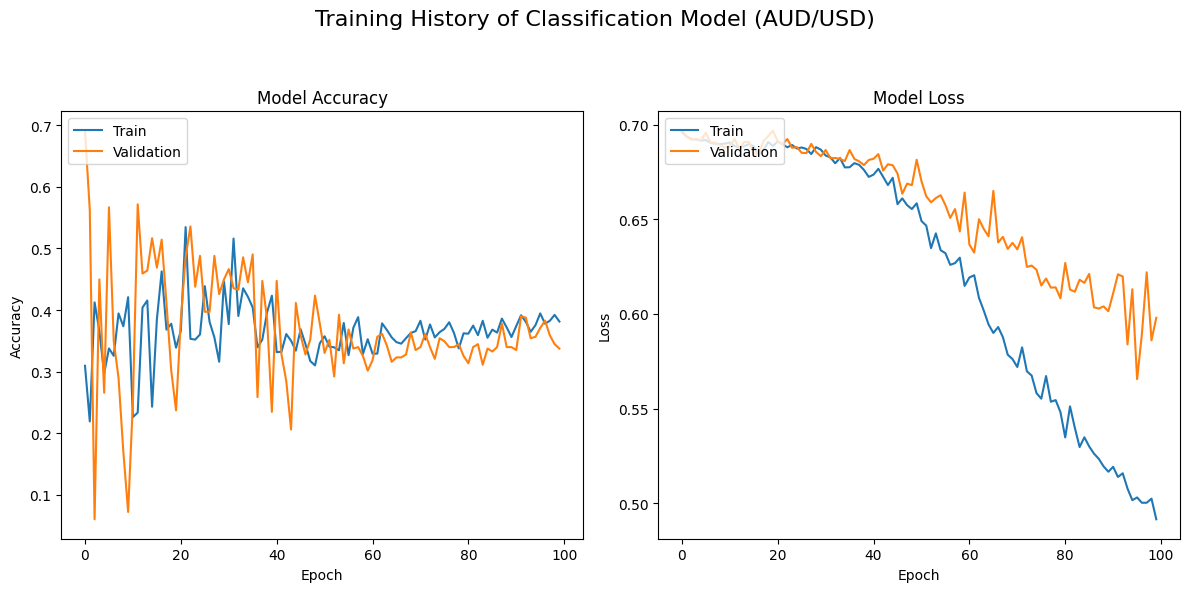

In [27]:
# Visualize training history (Classification Model)
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Tambahkan title utama
plt.suptitle('Training History of Classification Model (AUD/USD)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])  # beri ruang untuk suptitle
plt.show()


Grafik overfitting, namun yang digunakan adalah dari checkpoint best_model

### Save Model

In [28]:
# Save model
model_cls.save('AUDUSD_model_cls.h5')
# Save scaler
joblib.dump(scaler, 'AUDUSD_scaler.save')

['AUDUSD_scaler.save']

## Regresi

### Split Data

In [24]:
# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42, shuffle=False
    )


### Build Model

In [25]:
# Arsitektur model LSTM untuk regresi 5 output
model_reg = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train_reg.shape[1], X_train_reg.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(5)  # Output untuk Close_t+1 hingga Close_t+5
])

model_reg.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_reg.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,749 (92.77 KB)

 Trainable params: 23,749 (92.77 KB)

 Non-trainable params: 0 (0.00 B)

### Train

In [26]:
# Checkpoint untuk menyimpan model terbaik
checkpoint_reg = ModelCheckpoint('best_model_reg.h5', monitor='val_loss', save_best_only=True, verbose=1)

history_reg = model_reg.fit(
    X_train_reg, y_train_reg,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint_reg],
    verbose=1
)


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1614 - mae: 0.3115
Epoch 1: val_loss improved from inf to 0.00188, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.1596 - mae: 0.3091 - val_loss: 0.0019 - val_mae: 0.0348
Epoch 2/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0105 - mae: 0.0811
Epoch 2: val_loss improved from 0.00188 to 0.00100, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0105 - mae: 0.0809 - val_loss: 0.0010 - val_mae: 0.0242
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0063 - mae: 0.0625
Epoch 3: val_loss improved from 0.00100 to 0.00081, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0063 - mae: 0.0625 - val_loss: 8.0658e-04 - val_mae: 0.0223
Epoch 4/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0049 - mae: 0.0557
Epoch 4: val_loss improved from 0.00081 to 0.00067, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0049 - mae: 0.0557 - val_loss: 6.7043e-04 - val_mae: 0.0214
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0040 - mae: 0.0498
Epoch 5: val_loss did not improve from 0.00067
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0040 - mae: 0.0498 - val_loss: 0.0011 - val_mae: 0.0301
Epoch 6/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0033 - mae: 0.0456
Epoch 6: val_loss improved from 0.00067 to 0.00059, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0033 - mae: 0.0456 - val_loss: 5.9242e-04 - val_mae: 0.0206
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0029 - mae: 0.0426
Epoch 7: val_loss did not improve from 0.00059
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0029 - mae: 0.0426 - val_loss: 8.6538e-04 - val_mae: 0.0263
Epoch 8/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0027 - mae: 0.0414
Epoch 8: val_loss improved from 0.00059 to 0.00018, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0027 - mae: 0.0414 - val_loss: 1.7653e-04 - val_mae: 0.0106
Epoch 9/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0024 - mae: 0.0388
Epoch 9: val_loss did not improve from 0.00018
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0024 - mae: 0.0387 - val_loss: 7.5982e-04 - val_mae: 0.0248
Epoch 10/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0022 - mae: 0.0371
Epoch 10: val_loss did not improve from 0.00018
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0022 - mae: 0.0371 - val_loss: 3.6793e-04 - val_mae: 0.0162
Epoch 11/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0018 - mae: 0.0340
Epoch 11: val_loss did not improve from 0.00018
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0018 - mae: 0.0340 - val_loss: 4.8510e-04 - val_mae: 0.0192
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0017 - mae: 0.0330
Epoch 12: val_loss did not improve from 0.00018
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - 

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0012 - mae: 0.0272 - val_loss: 1.2762e-04 - val_mae: 0.0089
Epoch 18/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0011 - mae: 0.0262
Epoch 18: val_loss did not improve from 0.00013
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0011 - mae: 0.0262 - val_loss: 2.7413e-04 - val_mae: 0.0140
Epoch 19/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0010 - mae: 0.0252
Epoch 19: val_loss improved from 0.00013 to 0.00013, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0010 - mae: 0.0252 - val_loss: 1.2693e-04 - val_mae: 0.0089
Epoch 20/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 9.8050e-04 - mae: 0.0250
Epoch 20: val_loss did not improve from 0.00013
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 9.7994e-04 - mae: 0.0250 - val_loss: 1.6511e-04 - val_mae: 0.0101
Epoch 21/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 9.3018e-04 - mae: 0.0241
Epoch 21: val_loss did not improve from 0.00013
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 9.2882e-04 - mae: 0.0241 - val_loss: 1.2773e-04 - val_mae: 0.0089
Epoch 22/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7.9377e-04 - mae: 0.0220
Epoch 22: val_loss did not improve from 0.00013
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 7.9290e-04 - mae: 0.0220 - val_loss: 1.4670e-04 - val_mae: 0.0096
Epoch 23/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 7.8272e-04 - mae: 0.0222
Epoch 23: val_loss did not improve from 0.00013
53/53 ━━━━━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 6.7333e-04 - mae: 0.0203 - val_loss: 1.1543e-04 - val_mae: 0.0085
Epoch 25/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5.8785e-04 - mae: 0.0191
Epoch 25: val_loss did not improve from 0.00012
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 5.8815e-04 - mae: 0.0191 - val_loss: 1.1914e-04 - val_mae: 0.0086
Epoch 26/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 6.0192e-04 - mae: 0.0194
Epoch 26: val_loss did not improve from 0.00012
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 6.0181e-04 - mae: 0.0194 - val_loss: 1.5908e-04 - val_mae: 0.0100
Epoch 27/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 6.1799e-04 - mae: 0.0198
Epoch 27: val_loss improved from 0.00012 to 0.00011, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 6.1677e-04 - mae: 0.0198 - val_loss: 1.1319e-04 - val_mae: 0.0085
Epoch 28/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 4.4301e-04 - mae: 0.0166
Epoch 28: val_loss did not improve from 0.00011
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 4.4322e-04 - mae: 0.0166 - val_loss: 1.1734e-04 - val_mae: 0.0085
Epoch 29/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.4245e-04 - mae: 0.0164
Epoch 29: val_loss did not improve from 0.00011
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 4.4217e-04 - mae: 0.0164 - val_loss: 1.1840e-04 - val_mae: 0.0086
Epoch 30/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.8737e-04 - mae: 0.0155
Epoch 30: val_loss did not improve from 0.00011
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 3.8761e-04 - mae: 0.0155 - val_loss: 1.2023e-04 - val_mae: 0.0086
Epoch 31/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.5882e-04 - mae: 0.0148
Epoch 31: val_loss did not improve from 0.00011
53/53 ━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2.9252e-04 - mae: 0.0134 - val_loss: 1.0098e-04 - val_mae: 0.0080
Epoch 34/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.7460e-04 - mae: 0.0129
Epoch 34: val_loss did not improve from 0.00010
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 2.7447e-04 - mae: 0.0129 - val_loss: 1.1151e-04 - val_mae: 0.0083
Epoch 35/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.5506e-04 - mae: 0.0126
Epoch 35: val_loss did not improve from 0.00010
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2.5530e-04 - mae: 0.0126 - val_loss: 1.1583e-04 - val_mae: 0.0086
Epoch 36/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.4491e-04 - mae: 0.0121
Epoch 36: val_loss did not improve from 0.00010
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 2.4452e-04 - mae: 0.0121 - val_loss: 1.1568e-04 - val_mae: 0.0087
Epoch 37/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.2236e-04 - mae: 0.0119
Epoch 37: val_loss did not improve from 0.00010
53/53 ━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 1.4253e-04 - mae: 0.0094 - val_loss: 9.9440e-05 - val_mae: 0.0080
Epoch 46/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.2975e-04 - mae: 0.0089
Epoch 46: val_loss did not improve from 0.00010
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 1.2997e-04 - mae: 0.0089 - val_loss: 1.2787e-04 - val_mae: 0.0090
Epoch 47/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.4210e-04 - mae: 0.0092
Epoch 47: val_loss did not improve from 0.00010
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 1.4229e-04 - mae: 0.0092 - val_loss: 1.4080e-04 - val_mae: 0.0094
Epoch 48/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.3778e-04 - mae: 0.0091
Epoch 48: val_loss did not improve from 0.00010
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 1.3797e-04 - mae: 0.0091 - val_loss: 1.0376e-04 - val_mae: 0.0082
Epoch 49/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.4967e-04 - mae: 0.0095
Epoch 49: val_loss did not improve from 0.00010
53/53 ━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 1.3259e-04 - mae: 0.0090 - val_loss: 9.5812e-05 - val_mae: 0.0079
Epoch 53/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.2199e-04 - mae: 0.0086
Epoch 53: val_loss did not improve from 0.00010
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1.2196e-04 - mae: 0.0086 - val_loss: 1.2954e-04 - val_mae: 0.0090
Epoch 54/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.3867e-04 - mae: 0.0089
Epoch 54: val_loss did not improve from 0.00010
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 1.3838e-04 - mae: 0.0088 - val_loss: 1.5674e-04 - val_mae: 0.0103
Epoch 55/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.6160e-04 - mae: 0.0100
Epoch 55: val_loss did not improve from 0.00010
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 1.6083e-04 - mae: 0.0100 - val_loss: 9.9516e-05 - val_mae: 0.0080
Epoch 56/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.2194e-04 - mae: 0.0084
Epoch 56: val_loss did not improve from 0.00010
53/53 ━━

### Evaluation

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.6415e-05 - mae: 0.0069
Test Loss (MSE): 0.000074, Test MAE: 0.006665
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


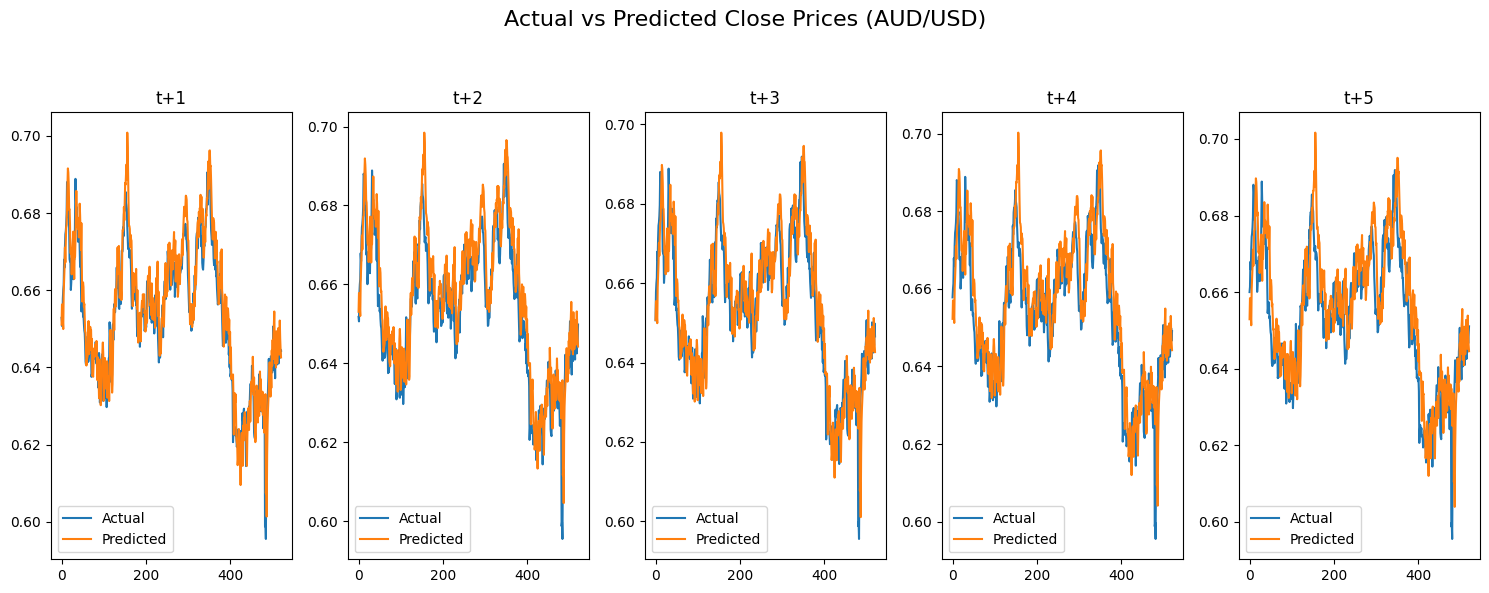

In [29]:
# Evaluasi
loss, mae = model_reg.evaluate(X_test_reg, y_test_reg)
print(f"Test Loss (MSE): {loss:.6f}, Test MAE: {mae:.6f}")

# Plot prediksi vs aktual
y_pred_reg = model_reg.predict(X_test_reg)

plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(y_test_reg[:, i], label='Actual')
    plt.plot(y_pred_reg[:, i], label='Predicted')
    plt.title(f"t+{i+1}")  # judul untuk masing-masing subplot
    plt.legend()

plt.suptitle("Actual vs Predicted Close Prices (AUD/USD)", fontsize=16)  # satu judul utama
plt.tight_layout(rect=[0, 0, 1, 0.93])  # agar tidak menabrak suptitle
plt.show()


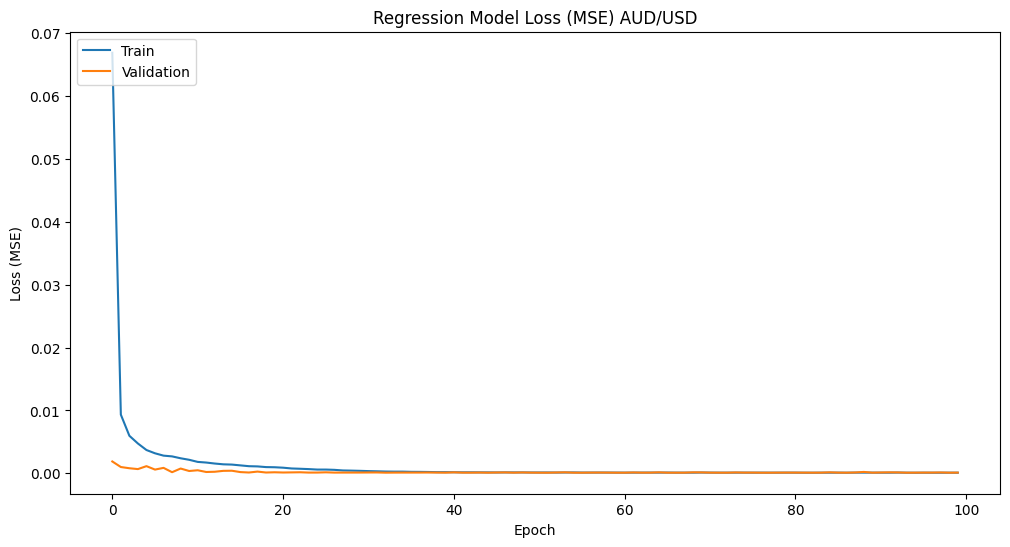

In [30]:
# Visualize training history (Regression Model)
plt.figure(figsize=(12, 6))

# Plot training & validation loss values for regression
plt.plot(history_reg.history['loss'])
plt.plot(history_reg.history['val_loss'])
plt.title('Regression Model Loss (MSE) AUD/USD')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Save Model

In [34]:
# Save model regresi
model_reg.save('AUDUSD_model_reg.h5')

# Inferensi

In [35]:
# Ambil window terakhir dari array features yang sudah disiapkan sebelumnya
latest_sequence = features[-window_size:]  # Shape (90, features)

# Ubah ke bentuk batch
X_latest = np.expand_dims(latest_sequence, axis=0).astype(np.float32)

# Get the last actual close price BEFORE scaling
last_actual_close = data['Close'].iloc[-window_size - 1] # Get the close price from the row *before* the latest sequence starts

# Prediksi probabilitas naik (tetap menggunakan model_cls)
y_pred_probs_cls = model_cls.predict(X_latest)
y_pred_cls = (y_pred_probs_cls > 0.5).astype(int)

# Prediksi harga penutupan (scaled, tetap menggunakan model_reg)
y_pred_price_scaled = model_reg.predict(X_latest)

# Kembalikan skala harga ke bentuk aslinya
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]

# Function to inverse transform manual only for the Close column
def inverse_minmax(value, vmin, vmax):
    return value * (vmax - vmin) + vmin - 0.0815

predicted_actual_prices = []
results = []
reference_price = last_actual_close # Start with the last actual close as the reference for t+1

print("📊 Prediksi Klasifikasi (Naik/Turun Relative to Previous Day's Predicted Close):")
print("📈 Prediksi Harga Penutupan (Close) Pekan Depan:")

for i in range(5):
    # Inverse transform the predicted scaled price for the current day (t+i+1)
    predicted_scaled_price = y_pred_price_scaled[0, i]
    predicted_original_price_absolute = inverse_minmax(predicted_scaled_price, close_min, close_max)

    # Determine classification relative to the reference price (previous day's close or predicted close)
    classification = "Naik" if predicted_original_price_absolute > reference_price else "Turun"

    print(f"t+{i+1}: {classification} (Probabilitas: {y_pred_probs_cls[0, i]:.2f}), Prediksi Harga: {predicted_original_price_absolute:.5f}")

    result = {
        f"t+{i+1}": {
            "classification": classification,
            "classification_probability": float(y_pred_probs_cls[0, i]),
            "predicted_close_price": float(predicted_original_price_absolute)
        }
    }
    results.append(result)

    # Update the reference price for the next iteration
    reference_price = predicted_original_price_absolute


# Menyimpan hasil ke file JSON
output_filename = "AUDUSD_prediksi.json"
with open(output_filename, 'w') as f:
    json.dump(results, f, indent=4)

print(f"\nHasil prediksi klasifikasi dan harga telah disimpan ke {output_filename}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
📊 Prediksi Klasifikasi (Naik/Turun Relative to Previous Day's Predicted Close):
📈 Prediksi Harga Penutupan (Close) Pekan Depan:
t+1: Naik (Probabilitas: 0.64), Prediksi Harga: 0.65190
t+2: Naik (Probabilitas: 0.63), Prediksi Harga: 0.65214
t+3: Turun (Probabilitas: 0.78), Prediksi Harga: 0.65174
t+4: Naik (Probabilitas: 0.92), Prediksi Harga: 0.65216
t+5: Naik (Probabilitas: 0.97), Prediksi Harga: 0.65247

Hasil prediksi klasifikasi dan harga telah disimpan ke AUDUSD_prediksi.json
